In [1]:
import pandas as pd
import numpy as np
import os
import xgboost as xgb
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import random
import lightgbm
import shap
import itertools
pd.options.mode.chained_assignment = None

os.chdir('/Users/stevengeorge/Documents/Github/fpl-analysis/')

from src.data.gw_features import add_gw_features
from src.features.custom_transformers import TimeSeriesFeatures
from src.models.constants import TIME_SERIES_FEATURES, STATIC_FEATURES

%matplotlib inline
pd.set_option('display.max_columns', None)
DATA_PATH = 'data/processed/'

/anaconda3/envs/fpl_analysis/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


__Get data for 2016/17 season to 2018/19 season__

In [30]:
fpl_data_all_seasons = pd.read_parquet(DATA_PATH + 'fpl_data_all_seasons.parquet')
print(fpl_data_all_seasons.shape)
fpl_data_all_seasons.head()

(67320, 73)


,name,assists,attempted_passes,big_chances_created,big_chances_missed,bonus,bps,clean_sheets,clearances_blocks_interceptions,completed_passes,creativity,dribbles,ea_index,errors_leading_to_goal,errors_leading_to_goal_attempt,fouls,goals_conceded,goals_scored,ict_index,influence,key_passes,loaned_in,loaned_out,minutes,offside,open_play_crosses,own_goals,penalties_conceded,penalties_missed,penalties_saved,recoveries,red_cards,saves,selected,tackled,tackles,target_missed,team_a_score,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,winning_goals,yellow_cards,gw,season,team_name,promoted_side,top_6_last_season,position_DEF,position_FWD,position_GK,position_MID,team_name_opponent,promoted_side_opponent,top_6_last_season_opponent,kickoff_month_Apr,kickoff_month_Aug,kickoff_month_Dec,kickoff_month_Feb,kickoff_month_Jan,kickoff_month_Mar,kickoff_month_May,kickoff_month_Nov,kickoff_month_Oct,kickoff_month_Sep,late_kickoff,early_kickoff,ID
0,aaron_cresswell,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,14023,0,0,0,1,2,0.0,0,0,0,0,5.5,False,0,0,1,2016-17,West Ham United,0,0,1,0,0,0,Chelsea,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1
1,aaron_cresswell,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,11531,0,0,0,0,1,0.0,0,-3002,79,3081,5.5,True,0,0,2,2016-17,West Ham United,0,0,1,0,0,0,Bournemouth,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
2,aaron_cresswell,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,9587,0,0,0,1,3,0.0,0,-2053,28,2081,5.4,False,0,0,3,2016-17,West Ham United,0,0,1,0,0,0,Manchester City,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1
3,aaron_cresswell,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,8427,0,0,0,4,2,0.0,0,-1221,45,1266,5.4,True,0,0,4,2016-17,West Ham United,0,0,1,0,0,0,Watford,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1
4,aaron_cresswell,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,7933,0,0,0,2,4,0.0,0,-520,29,549,5.4,False,0,0,5,2016-17,West Ham United,0,0,1,0,0,0,West Bromwich Albion,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1


__Get 2019/20 GW 1 data__

In [31]:
gw_1_static_features_201920 = pd.read_parquet('data/processed/gameweek_1_static_features_201920')
print(gw_1_static_features_201920.shape)
gw_1_static_features_201920.head()

(454, 27)


,value,gw,was_home,name,kickoff_month_Aug,kickoff_month_Apr,kickoff_month_Dec,kickoff_month_Feb,kickoff_month_Jan,kickoff_month_Mar,kickoff_month_May,kickoff_month_Nov,kickoff_month_Oct,kickoff_month_Sep,late_kickoff,early_kickoff,season,position_DEF,position_FWD,position_GK,position_MID,team_name,promoted_side,top_6_last_season,team_name_opponent,promoted_side_opponent,top_6_last_season_opponent
0,5.5,1,False,shkodran_mustafi,1,0,0,0,0,0,0,0,0,0,0,0,2019-20,1,0,0,0,Arsenal,0,1,Newcastle United,0,0
1,5.5,1,False,hector_bellerin,1,0,0,0,0,0,0,0,0,0,0,0,2019-20,1,0,0,0,Arsenal,0,1,Newcastle United,0,0
2,5.5,1,False,sead_kolasinac,1,0,0,0,0,0,0,0,0,0,0,0,2019-20,1,0,0,0,Arsenal,0,1,Newcastle United,0,0
3,5.0,1,False,ainsley_maitland-niles,1,0,0,0,0,0,0,0,0,0,0,0,2019-20,1,0,0,0,Arsenal,0,1,Newcastle United,0,0
4,5.0,1,False,sokratis_papastathopoulos,1,0,0,0,0,0,0,0,0,0,0,0,2019-20,1,0,0,0,Arsenal,0,1,Newcastle United,0,0


In [32]:
fpl_data_all_seasons = fpl_data_all_seasons.append(gw_1_static_features_201920, sort=False)

fpl_data_all_seasons['season_order'] = fpl_data_all_seasons['season'].map({
    '2016-17': 1,
    '2017-18': 2,
    '2018-19': 3,
    '2019-20': 4
})

In [33]:
fpl_data_all_seasons.sort_values(['name', 'season_order', 'gw'], inplace=True)
fpl_data_all_seasons.reset_index(drop=True, inplace=True)

Create new ID

In [34]:
fpl_data_all_seasons.drop('ID', axis=1, inplace=True)

In [35]:
id_df = fpl_data_all_seasons.groupby(['name']).count().reset_index()[['name']]
id_df['ID'] = id_df.index + 1
print(id_df.shape)
id_df.head()

(1146, 2)


,name,ID
0,aaron_cresswell,1
1,aaron_lennon,2
2,aaron_mooy,3
3,aaron_ramsdale,4
4,aaron_ramsey,5


In [8]:
fpl_data_all_seasons = fpl_data_all_seasons.merge(id_df, how='left', on=['name'])

### Shift forward static features e.g. next opponnent etc.

In [9]:
fpl_data_all_seasons.head(1)

,name,assists,attempted_passes,big_chances_created,big_chances_missed,bonus,bps,clean_sheets,clearances_blocks_interceptions,completed_passes,creativity,dribbles,ea_index,errors_leading_to_goal,errors_leading_to_goal_attempt,fouls,goals_conceded,goals_scored,ict_index,influence,key_passes,loaned_in,loaned_out,minutes,offside,open_play_crosses,own_goals,penalties_conceded,penalties_missed,penalties_saved,recoveries,red_cards,saves,selected,tackled,tackles,target_missed,team_a_score,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,winning_goals,yellow_cards,gw,season,team_name,promoted_side,top_6_last_season,position_DEF,position_FWD,position_GK,position_MID,team_name_opponent,promoted_side_opponent,top_6_last_season_opponent,kickoff_month_Apr,kickoff_month_Aug,kickoff_month_Dec,kickoff_month_Feb,kickoff_month_Jan,kickoff_month_Mar,kickoff_month_May,kickoff_month_Nov,kickoff_month_Oct,kickoff_month_Sep,late_kickoff,early_kickoff,season_order,ID
0,aaron_cresswell,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14023.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,5.5,False,0.0,0.0,1,2016-17,West Ham United,0,0,1,0,0,0,Chelsea,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,1


In [10]:
for feature in ['value', 'was_home', 'promoted_side_opponent', 'top_6_last_season_opponent', 'kickoff_month_Apr', 'kickoff_month_Aug', 'kickoff_month_Dec',
                'kickoff_month_Feb', 'kickoff_month_Jan', 'kickoff_month_Mar', 'kickoff_month_May', 'kickoff_month_Nov', 'kickoff_month_Oct', 
                'kickoff_month_Sep', 'late_kickoff', 'early_kickoff']:
    fpl_data_all_seasons[f'next_match_{feature}'] = fpl_data_all_seasons.groupby('name')[f'{feature}'].shift(-1)

In [11]:
fpl_data_all_seasons.head(2)

,name,assists,attempted_passes,big_chances_created,big_chances_missed,bonus,bps,clean_sheets,clearances_blocks_interceptions,completed_passes,creativity,dribbles,ea_index,errors_leading_to_goal,errors_leading_to_goal_attempt,fouls,goals_conceded,goals_scored,ict_index,influence,key_passes,loaned_in,loaned_out,minutes,offside,open_play_crosses,own_goals,penalties_conceded,penalties_missed,penalties_saved,recoveries,red_cards,saves,selected,tackled,tackles,target_missed,team_a_score,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,winning_goals,yellow_cards,gw,season,team_name,promoted_side,top_6_last_season,position_DEF,position_FWD,position_GK,position_MID,team_name_opponent,promoted_side_opponent,top_6_last_season_opponent,kickoff_month_Apr,kickoff_month_Aug,kickoff_month_Dec,kickoff_month_Feb,kickoff_month_Jan,kickoff_month_Mar,kickoff_month_May,kickoff_month_Nov,kickoff_month_Oct,kickoff_month_Sep,late_kickoff,early_kickoff,season_order,ID,next_match_value,next_match_was_home,next_match_promoted_side_opponent,next_match_top_6_last_season_opponent,next_match_kickoff_month_Apr,next_match_kickoff_month_Aug,next_match_kickoff_month_Dec,next_match_kickoff_month_Feb,next_match_kickoff_month_Jan,next_match_kickoff_month_Mar,next_match_kickoff_month_May,next_match_kickoff_month_Nov,next_match_kickoff_month_Oct,next_match_kickoff_month_Sep,next_match_late_kickoff,next_match_early_kickoff
0,aaron_cresswell,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14023.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,5.5,False,0.0,0.0,1,2016-17,West Ham United,0,0,1,0,0,0,Chelsea,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,1,5.5,True,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,aaron_cresswell,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11531.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-3002.0,79.0,3081.0,5.5,True,0.0,0.0,2,2016-17,West Ham United,0,0,1,0,0,0,Bournemouth,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,5.4,False,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Create time series features

In [12]:
ts_features = TimeSeriesFeatures(halflife=4, max_lag=4, max_diff=4, columns=TIME_SERIES_FEATURES)

In [13]:
%%time
fpl_data_all_seasons_with_ts = ts_features.fit_transform(fpl_data_all_seasons)
print(fpl_data_all_seasons_with_ts.shape)

(67774, 504)
CPU times: user 4min 38s, sys: 1min 50s, total: 6min 29s
Wall time: 5min 36s


In [14]:
fpl_data_all_seasons_with_ts.to_parquet('fpl_data_all_seasons_with_ts.parquet', index=False)

In [2]:
fpl_data_all_seasons_with_ts = pd.read_parquet('fpl_data_all_seasons_with_ts.parquet')

In [3]:
fpl_data_all_seasons_with_ts.head()

,name,assists,attempted_passes,big_chances_created,big_chances_missed,bonus,bps,clean_sheets,clearances_blocks_interceptions,completed_passes,creativity,dribbles,ea_index,errors_leading_to_goal,errors_leading_to_goal_attempt,fouls,goals_conceded,goals_scored,ict_index,influence,key_passes,loaned_in,loaned_out,minutes,offside,open_play_crosses,own_goals,penalties_conceded,penalties_missed,penalties_saved,recoveries,red_cards,saves,selected,tackled,tackles,target_missed,team_a_score,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,winning_goals,yellow_cards,gw,season,team_name,promoted_side,top_6_last_season,position_DEF,position_FWD,position_GK,position_MID,team_name_opponent,promoted_side_opponent,top_6_last_season_opponent,kickoff_month_Apr,kickoff_month_Aug,kickoff_month_Dec,kickoff_month_Feb,kickoff_month_Jan,kickoff_month_Mar,kickoff_month_May,kickoff_month_Nov,kickoff_month_Oct,kickoff_month_Sep,late_kickoff,early_kickoff,season_order,ID,next_match_value,next_match_was_home,next_match_promoted_side_opponent,next_match_top_6_last_season_opponent,next_match_kickoff_month_Apr,next_match_kickoff_month_Aug,next_match_kickoff_month_Dec,next_match_kickoff_month_Feb,next_match_kickoff_month_Jan,next_match_kickoff_month_Mar,next_match_kickoff_month_May,next_match_kickoff_month_Nov,next_match_kickoff_month_Oct,next_match_kickoff_month_Sep,next_match_late_kickoff,next_match_early_kickoff,assists_EMA,assists_L1,assists_L2,assists_L3,assists_L4,assists_D1,assists_D2,assists_D3,assists_D4,bonus_EMA,bonus_L1,bonus_L2,bonus_L3,bonus_L4,bonus_D1,bonus_D2,bonus_D3,bonus_D4,target_missed_EMA,target_missed_L1,target_missed_L2,target_missed_L3,target_missed_L4,target_missed_D1,target_missed_D2,target_missed_D3,target_missed_D4,errors_leading_to_goal_attempt_EMA,errors_leading_to_goal_attempt_L1,errors_leading_to_goal_attempt_L2,errors_leading_to_goal_attempt_L3,errors_leading_to_goal_attempt_L4,errors_leading_to_goal_attempt_D1,errors_leading_to_goal_attempt_D2,errors_leading_to_goal_attempt_D3,errors_leading_to_goal_attempt_D4,creativity_EMA,creativity_L1,creativity_L2,creativity_L3,creativity_L4,creativity_D1,creativity_D2,creativity_D3,creativity_D4,key_passes_EMA,key_passes_L1,key_passes_L2,key_passes_L3,key_passes_L4,key_passes_D1,key_passes_D2,key_passes_D3,key_passes_D4,yellow_cards_EMA,yellow_cards_L1,yellow_cards_L2,yellow_cards_L3,yellow_cards_L4,yellow_cards_D1,yellow_cards_D2,yellow_cards_D3,yellow_cards_D4,loaned_in_EMA,loaned_in_L1,loaned_in_L2,loaned_in_L3,loaned_in_L4,loaned_in_D1,loaned_in_D2,loaned_in_D3,loaned_in_D4,team_a_score_EMA,team_a_score_L1,team_a_score_L2,team_a_score_L3,team_a_score_L4,team_a_score_D1,team_a_score_D2,team_a_score_D3,team_a_score_D4,team_h_score_EMA,team_h_score_L1,team_h_score_L2,team_h_score_L3,team_h_score_L4,team_h_score_D1,team_h_score_D2,team_h_score_D3,team_h_score_D4,clearances_blocks_interceptions_EMA,clearances_blocks_interceptions_L1,clearances_blocks_interceptions_L2,clearances_blocks_interceptions_L3,clearances_blocks_interceptions_L4,clearances_blocks_interceptions_D1,clearances_blocks_interceptions_D2,clearances_blocks_interceptions_D3,clearances_blocks_interceptions_D4,offside_EMA,offside_L1,offside_L2,offside_L3,offside_L4,offside_D1,offside_D2,offside_D3,offside_D4,dribbles_EMA,dribbles_L1,dribbles_L2,dribbles_L3,dribbles_L4,dribbles_D1,dribbles_D2,dribbles_D3,dribbles_D4,loaned_out_EMA,loaned_out_L1,loaned_out_L2,loaned_out_L3,loaned_out_L4,loaned_out_D1,loaned_out_D2,loaned_out_D3,loaned_out_D4,selected_EMA,selected_L1,selected_L2,selected_L3,selected_L4,selected_D1,selected_D2,selected_D3,selected_D4,big_chances_missed_EMA,big_chances_missed_L1,big_chances_missed_L2,big_chances_missed_L3,big_chances_missed_L4,big_chances_missed_D1,big_chances_missed_D2,big_chances_missed_D3,big_chances_missed_D4,ict_index_EMA,ict_index_L1,ict_index_L2,ict_index_L3,ict_index_L4,ict_index_D1,ict_index_D2,ict_index_D3,ict_index_D4,red_cards_EMA,red_cards

__TODO: Replace with Imputer__

In [4]:
mean_total_points = fpl_data_all_seasons_with_ts['total_points'].mean()
mean_total_points

1.3724598930481284

In [5]:
# Target cannot contain any nulls
fpl_data_all_seasons_with_ts['total_points_plus_1_gw'] = fpl_data_all_seasons_with_ts.groupby(['name'])['total_points'].shift(-1).fillna(mean_total_points)

In [6]:
print(fpl_data_all_seasons_with_ts.shape)
fpl_data_all_seasons_with_ts.head()

(67774, 505)


,name,assists,attempted_passes,big_chances_created,big_chances_missed,bonus,bps,clean_sheets,clearances_blocks_interceptions,completed_passes,creativity,dribbles,ea_index,errors_leading_to_goal,errors_leading_to_goal_attempt,fouls,goals_conceded,goals_scored,ict_index,influence,key_passes,loaned_in,loaned_out,minutes,offside,open_play_crosses,own_goals,penalties_conceded,penalties_missed,penalties_saved,recoveries,red_cards,saves,selected,tackled,tackles,target_missed,team_a_score,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,winning_goals,yellow_cards,gw,season,team_name,promoted_side,top_6_last_season,position_DEF,position_FWD,position_GK,position_MID,team_name_opponent,promoted_side_opponent,top_6_last_season_opponent,kickoff_month_Apr,kickoff_month_Aug,kickoff_month_Dec,kickoff_month_Feb,kickoff_month_Jan,kickoff_month_Mar,kickoff_month_May,kickoff_month_Nov,kickoff_month_Oct,kickoff_month_Sep,late_kickoff,early_kickoff,season_order,ID,next_match_value,next_match_was_home,next_match_promoted_side_opponent,next_match_top_6_last_season_opponent,next_match_kickoff_month_Apr,next_match_kickoff_month_Aug,next_match_kickoff_month_Dec,next_match_kickoff_month_Feb,next_match_kickoff_month_Jan,next_match_kickoff_month_Mar,next_match_kickoff_month_May,next_match_kickoff_month_Nov,next_match_kickoff_month_Oct,next_match_kickoff_month_Sep,next_match_late_kickoff,next_match_early_kickoff,assists_EMA,assists_L1,assists_L2,assists_L3,assists_L4,assists_D1,assists_D2,assists_D3,assists_D4,bonus_EMA,bonus_L1,bonus_L2,bonus_L3,bonus_L4,bonus_D1,bonus_D2,bonus_D3,bonus_D4,target_missed_EMA,target_missed_L1,target_missed_L2,target_missed_L3,target_missed_L4,target_missed_D1,target_missed_D2,target_missed_D3,target_missed_D4,errors_leading_to_goal_attempt_EMA,errors_leading_to_goal_attempt_L1,errors_leading_to_goal_attempt_L2,errors_leading_to_goal_attempt_L3,errors_leading_to_goal_attempt_L4,errors_leading_to_goal_attempt_D1,errors_leading_to_goal_attempt_D2,errors_leading_to_goal_attempt_D3,errors_leading_to_goal_attempt_D4,creativity_EMA,creativity_L1,creativity_L2,creativity_L3,creativity_L4,creativity_D1,creativity_D2,creativity_D3,creativity_D4,key_passes_EMA,key_passes_L1,key_passes_L2,key_passes_L3,key_passes_L4,key_passes_D1,key_passes_D2,key_passes_D3,key_passes_D4,yellow_cards_EMA,yellow_cards_L1,yellow_cards_L2,yellow_cards_L3,yellow_cards_L4,yellow_cards_D1,yellow_cards_D2,yellow_cards_D3,yellow_cards_D4,loaned_in_EMA,loaned_in_L1,loaned_in_L2,loaned_in_L3,loaned_in_L4,loaned_in_D1,loaned_in_D2,loaned_in_D3,loaned_in_D4,team_a_score_EMA,team_a_score_L1,team_a_score_L2,team_a_score_L3,team_a_score_L4,team_a_score_D1,team_a_score_D2,team_a_score_D3,team_a_score_D4,team_h_score_EMA,team_h_score_L1,team_h_score_L2,team_h_score_L3,team_h_score_L4,team_h_score_D1,team_h_score_D2,team_h_score_D3,team_h_score_D4,clearances_blocks_interceptions_EMA,clearances_blocks_interceptions_L1,clearances_blocks_interceptions_L2,clearances_blocks_interceptions_L3,clearances_blocks_interceptions_L4,clearances_blocks_interceptions_D1,clearances_blocks_interceptions_D2,clearances_blocks_interceptions_D3,clearances_blocks_interceptions_D4,offside_EMA,offside_L1,offside_L2,offside_L3,offside_L4,offside_D1,offside_D2,offside_D3,offside_D4,dribbles_EMA,dribbles_L1,dribbles_L2,dribbles_L3,dribbles_L4,dribbles_D1,dribbles_D2,dribbles_D3,dribbles_D4,loaned_out_EMA,loaned_out_L1,loaned_out_L2,loaned_out_L3,loaned_out_L4,loaned_out_D1,loaned_out_D2,loaned_out_D3,loaned_out_D4,selected_EMA,selected_L1,selected_L2,selected_L3,selected_L4,selected_D1,selected_D2,selected_D3,selected_D4,big_chances_missed_EMA,big_chances_missed_L1,big_chances_missed_L2,big_chances_missed_L3,big_chances_missed_L4,big_chances_missed_D1,big_chances_missed_D2,big_chances_missed_D3,big_chances_missed_D4,ict_index_EMA,ict_index_L1,ict_index_L2,ict_index_L3,ict_index_L4,ict_index_D1,ict_index_D2,ict_index_D3,ict_index_D4,red_cards_EMA,red_cards

### Drop 2019-20 row 
__Mostly nulls and any valuable information brought into GW 38 of previous season__

In [7]:
fpl_data_all_seasons_with_ts = fpl_data_all_seasons_with_ts[fpl_data_all_seasons_with_ts['season_order'] != 4]

In [8]:
# The data we will use to predict expected points in first GW of 2019/20 season
test = fpl_data_all_seasons_with_ts[
    (fpl_data_all_seasons_with_ts['season_order'] == 3) & (fpl_data_all_seasons_with_ts['gw'] == 38)
]

In [9]:
test.head()

,name,assists,attempted_passes,big_chances_created,big_chances_missed,bonus,bps,clean_sheets,clearances_blocks_interceptions,completed_passes,creativity,dribbles,ea_index,errors_leading_to_goal,errors_leading_to_goal_attempt,fouls,goals_conceded,goals_scored,ict_index,influence,key_passes,loaned_in,loaned_out,minutes,offside,open_play_crosses,own_goals,penalties_conceded,penalties_missed,penalties_saved,recoveries,red_cards,saves,selected,tackled,tackles,target_missed,team_a_score,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,winning_goals,yellow_cards,gw,season,team_name,promoted_side,top_6_last_season,position_DEF,position_FWD,position_GK,position_MID,team_name_opponent,promoted_side_opponent,top_6_last_season_opponent,kickoff_month_Apr,kickoff_month_Aug,kickoff_month_Dec,kickoff_month_Feb,kickoff_month_Jan,kickoff_month_Mar,kickoff_month_May,kickoff_month_Nov,kickoff_month_Oct,kickoff_month_Sep,late_kickoff,early_kickoff,season_order,ID,next_match_value,next_match_was_home,next_match_promoted_side_opponent,next_match_top_6_last_season_opponent,next_match_kickoff_month_Apr,next_match_kickoff_month_Aug,next_match_kickoff_month_Dec,next_match_kickoff_month_Feb,next_match_kickoff_month_Jan,next_match_kickoff_month_Mar,next_match_kickoff_month_May,next_match_kickoff_month_Nov,next_match_kickoff_month_Oct,next_match_kickoff_month_Sep,next_match_late_kickoff,next_match_early_kickoff,assists_EMA,assists_L1,assists_L2,assists_L3,assists_L4,assists_D1,assists_D2,assists_D3,assists_D4,bonus_EMA,bonus_L1,bonus_L2,bonus_L3,bonus_L4,bonus_D1,bonus_D2,bonus_D3,bonus_D4,target_missed_EMA,target_missed_L1,target_missed_L2,target_missed_L3,target_missed_L4,target_missed_D1,target_missed_D2,target_missed_D3,target_missed_D4,errors_leading_to_goal_attempt_EMA,errors_leading_to_goal_attempt_L1,errors_leading_to_goal_attempt_L2,errors_leading_to_goal_attempt_L3,errors_leading_to_goal_attempt_L4,errors_leading_to_goal_attempt_D1,errors_leading_to_goal_attempt_D2,errors_leading_to_goal_attempt_D3,errors_leading_to_goal_attempt_D4,creativity_EMA,creativity_L1,creativity_L2,creativity_L3,creativity_L4,creativity_D1,creativity_D2,creativity_D3,creativity_D4,key_passes_EMA,key_passes_L1,key_passes_L2,key_passes_L3,key_passes_L4,key_passes_D1,key_passes_D2,key_passes_D3,key_passes_D4,yellow_cards_EMA,yellow_cards_L1,yellow_cards_L2,yellow_cards_L3,yellow_cards_L4,yellow_cards_D1,yellow_cards_D2,yellow_cards_D3,yellow_cards_D4,loaned_in_EMA,loaned_in_L1,loaned_in_L2,loaned_in_L3,loaned_in_L4,loaned_in_D1,loaned_in_D2,loaned_in_D3,loaned_in_D4,team_a_score_EMA,team_a_score_L1,team_a_score_L2,team_a_score_L3,team_a_score_L4,team_a_score_D1,team_a_score_D2,team_a_score_D3,team_a_score_D4,team_h_score_EMA,team_h_score_L1,team_h_score_L2,team_h_score_L3,team_h_score_L4,team_h_score_D1,team_h_score_D2,team_h_score_D3,team_h_score_D4,clearances_blocks_interceptions_EMA,clearances_blocks_interceptions_L1,clearances_blocks_interceptions_L2,clearances_blocks_interceptions_L3,clearances_blocks_interceptions_L4,clearances_blocks_interceptions_D1,clearances_blocks_interceptions_D2,clearances_blocks_interceptions_D3,clearances_blocks_interceptions_D4,offside_EMA,offside_L1,offside_L2,offside_L3,offside_L4,offside_D1,offside_D2,offside_D3,offside_D4,dribbles_EMA,dribbles_L1,dribbles_L2,dribbles_L3,dribbles_L4,dribbles_D1,dribbles_D2,dribbles_D3,dribbles_D4,loaned_out_EMA,loaned_out_L1,loaned_out_L2,loaned_out_L3,loaned_out_L4,loaned_out_D1,loaned_out_D2,loaned_out_D3,loaned_out_D4,selected_EMA,selected_L1,selected_L2,selected_L3,selected_L4,selected_D1,selected_D2,selected_D3,selected_D4,big_chances_missed_EMA,big_chances_missed_L1,big_chances_missed_L2,big_chances_missed_L3,big_chances_missed_L4,big_chances_missed_D1,big_chances_missed_D2,big_chances_missed_D3,big_chances_missed_D4,ict_index_EMA,ict_index_L1,ict_index_L2,ict_index_L3,ict_index_L4,ict_index_D1,ict_index_D2,ict_index_D3,ict_index_D4,red_cards_EMA,red_cards

In [10]:
test.shape

(619, 505)

In [11]:
train = fpl_data_all_seasons_with_ts[
    ~((fpl_data_all_seasons_with_ts['season_order'] == 3) & (fpl_data_all_seasons_with_ts['gw'] == 38))
]

In [12]:
train.head()

,name,assists,attempted_passes,big_chances_created,big_chances_missed,bonus,bps,clean_sheets,clearances_blocks_interceptions,completed_passes,creativity,dribbles,ea_index,errors_leading_to_goal,errors_leading_to_goal_attempt,fouls,goals_conceded,goals_scored,ict_index,influence,key_passes,loaned_in,loaned_out,minutes,offside,open_play_crosses,own_goals,penalties_conceded,penalties_missed,penalties_saved,recoveries,red_cards,saves,selected,tackled,tackles,target_missed,team_a_score,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,winning_goals,yellow_cards,gw,season,team_name,promoted_side,top_6_last_season,position_DEF,position_FWD,position_GK,position_MID,team_name_opponent,promoted_side_opponent,top_6_last_season_opponent,kickoff_month_Apr,kickoff_month_Aug,kickoff_month_Dec,kickoff_month_Feb,kickoff_month_Jan,kickoff_month_Mar,kickoff_month_May,kickoff_month_Nov,kickoff_month_Oct,kickoff_month_Sep,late_kickoff,early_kickoff,season_order,ID,next_match_value,next_match_was_home,next_match_promoted_side_opponent,next_match_top_6_last_season_opponent,next_match_kickoff_month_Apr,next_match_kickoff_month_Aug,next_match_kickoff_month_Dec,next_match_kickoff_month_Feb,next_match_kickoff_month_Jan,next_match_kickoff_month_Mar,next_match_kickoff_month_May,next_match_kickoff_month_Nov,next_match_kickoff_month_Oct,next_match_kickoff_month_Sep,next_match_late_kickoff,next_match_early_kickoff,assists_EMA,assists_L1,assists_L2,assists_L3,assists_L4,assists_D1,assists_D2,assists_D3,assists_D4,bonus_EMA,bonus_L1,bonus_L2,bonus_L3,bonus_L4,bonus_D1,bonus_D2,bonus_D3,bonus_D4,target_missed_EMA,target_missed_L1,target_missed_L2,target_missed_L3,target_missed_L4,target_missed_D1,target_missed_D2,target_missed_D3,target_missed_D4,errors_leading_to_goal_attempt_EMA,errors_leading_to_goal_attempt_L1,errors_leading_to_goal_attempt_L2,errors_leading_to_goal_attempt_L3,errors_leading_to_goal_attempt_L4,errors_leading_to_goal_attempt_D1,errors_leading_to_goal_attempt_D2,errors_leading_to_goal_attempt_D3,errors_leading_to_goal_attempt_D4,creativity_EMA,creativity_L1,creativity_L2,creativity_L3,creativity_L4,creativity_D1,creativity_D2,creativity_D3,creativity_D4,key_passes_EMA,key_passes_L1,key_passes_L2,key_passes_L3,key_passes_L4,key_passes_D1,key_passes_D2,key_passes_D3,key_passes_D4,yellow_cards_EMA,yellow_cards_L1,yellow_cards_L2,yellow_cards_L3,yellow_cards_L4,yellow_cards_D1,yellow_cards_D2,yellow_cards_D3,yellow_cards_D4,loaned_in_EMA,loaned_in_L1,loaned_in_L2,loaned_in_L3,loaned_in_L4,loaned_in_D1,loaned_in_D2,loaned_in_D3,loaned_in_D4,team_a_score_EMA,team_a_score_L1,team_a_score_L2,team_a_score_L3,team_a_score_L4,team_a_score_D1,team_a_score_D2,team_a_score_D3,team_a_score_D4,team_h_score_EMA,team_h_score_L1,team_h_score_L2,team_h_score_L3,team_h_score_L4,team_h_score_D1,team_h_score_D2,team_h_score_D3,team_h_score_D4,clearances_blocks_interceptions_EMA,clearances_blocks_interceptions_L1,clearances_blocks_interceptions_L2,clearances_blocks_interceptions_L3,clearances_blocks_interceptions_L4,clearances_blocks_interceptions_D1,clearances_blocks_interceptions_D2,clearances_blocks_interceptions_D3,clearances_blocks_interceptions_D4,offside_EMA,offside_L1,offside_L2,offside_L3,offside_L4,offside_D1,offside_D2,offside_D3,offside_D4,dribbles_EMA,dribbles_L1,dribbles_L2,dribbles_L3,dribbles_L4,dribbles_D1,dribbles_D2,dribbles_D3,dribbles_D4,loaned_out_EMA,loaned_out_L1,loaned_out_L2,loaned_out_L3,loaned_out_L4,loaned_out_D1,loaned_out_D2,loaned_out_D3,loaned_out_D4,selected_EMA,selected_L1,selected_L2,selected_L3,selected_L4,selected_D1,selected_D2,selected_D3,selected_D4,big_chances_missed_EMA,big_chances_missed_L1,big_chances_missed_L2,big_chances_missed_L3,big_chances_missed_L4,big_chances_missed_D1,big_chances_missed_D2,big_chances_missed_D3,big_chances_missed_D4,ict_index_EMA,ict_index_L1,ict_index_L2,ict_index_L3,ict_index_L4,ict_index_D1,ict_index_D2,ict_index_D3,ict_index_D4,red_cards_EMA,red_cards

### Fit model on everything except GW 38 of 2019-20

In [13]:
train_copy = train.copy()

In [14]:
train_copy.drop(
    ['total_points', 'name', 'season', 'team_name', 'team_name_opponent'],
    axis=1,
    inplace=True
)

In [15]:
train_copy.head()

,assists,attempted_passes,big_chances_created,big_chances_missed,bonus,bps,clean_sheets,clearances_blocks_interceptions,completed_passes,creativity,dribbles,ea_index,errors_leading_to_goal,errors_leading_to_goal_attempt,fouls,goals_conceded,goals_scored,ict_index,influence,key_passes,loaned_in,loaned_out,minutes,offside,open_play_crosses,own_goals,penalties_conceded,penalties_missed,penalties_saved,recoveries,red_cards,saves,selected,tackled,tackles,target_missed,team_a_score,team_h_score,threat,transfers_balance,transfers_in,transfers_out,value,was_home,winning_goals,yellow_cards,gw,promoted_side,top_6_last_season,position_DEF,position_FWD,position_GK,position_MID,promoted_side_opponent,top_6_last_season_opponent,kickoff_month_Apr,kickoff_month_Aug,kickoff_month_Dec,kickoff_month_Feb,kickoff_month_Jan,kickoff_month_Mar,kickoff_month_May,kickoff_month_Nov,kickoff_month_Oct,kickoff_month_Sep,late_kickoff,early_kickoff,season_order,ID,next_match_value,next_match_was_home,next_match_promoted_side_opponent,next_match_top_6_last_season_opponent,next_match_kickoff_month_Apr,next_match_kickoff_month_Aug,next_match_kickoff_month_Dec,next_match_kickoff_month_Feb,next_match_kickoff_month_Jan,next_match_kickoff_month_Mar,next_match_kickoff_month_May,next_match_kickoff_month_Nov,next_match_kickoff_month_Oct,next_match_kickoff_month_Sep,next_match_late_kickoff,next_match_early_kickoff,assists_EMA,assists_L1,assists_L2,assists_L3,assists_L4,assists_D1,assists_D2,assists_D3,assists_D4,bonus_EMA,bonus_L1,bonus_L2,bonus_L3,bonus_L4,bonus_D1,bonus_D2,bonus_D3,bonus_D4,target_missed_EMA,target_missed_L1,target_missed_L2,target_missed_L3,target_missed_L4,target_missed_D1,target_missed_D2,target_missed_D3,target_missed_D4,errors_leading_to_goal_attempt_EMA,errors_leading_to_goal_attempt_L1,errors_leading_to_goal_attempt_L2,errors_leading_to_goal_attempt_L3,errors_leading_to_goal_attempt_L4,errors_leading_to_goal_attempt_D1,errors_leading_to_goal_attempt_D2,errors_leading_to_goal_attempt_D3,errors_leading_to_goal_attempt_D4,creativity_EMA,creativity_L1,creativity_L2,creativity_L3,creativity_L4,creativity_D1,creativity_D2,creativity_D3,creativity_D4,key_passes_EMA,key_passes_L1,key_passes_L2,key_passes_L3,key_passes_L4,key_passes_D1,key_passes_D2,key_passes_D3,key_passes_D4,yellow_cards_EMA,yellow_cards_L1,yellow_cards_L2,yellow_cards_L3,yellow_cards_L4,yellow_cards_D1,yellow_cards_D2,yellow_cards_D3,yellow_cards_D4,loaned_in_EMA,loaned_in_L1,loaned_in_L2,loaned_in_L3,loaned_in_L4,loaned_in_D1,loaned_in_D2,loaned_in_D3,loaned_in_D4,team_a_score_EMA,team_a_score_L1,team_a_score_L2,team_a_score_L3,team_a_score_L4,team_a_score_D1,team_a_score_D2,team_a_score_D3,team_a_score_D4,team_h_score_EMA,team_h_score_L1,team_h_score_L2,team_h_score_L3,team_h_score_L4,team_h_score_D1,team_h_score_D2,team_h_score_D3,team_h_score_D4,clearances_blocks_interceptions_EMA,clearances_blocks_interceptions_L1,clearances_blocks_interceptions_L2,clearances_blocks_interceptions_L3,clearances_blocks_interceptions_L4,clearances_blocks_interceptions_D1,clearances_blocks_interceptions_D2,clearances_blocks_interceptions_D3,clearances_blocks_interceptions_D4,offside_EMA,offside_L1,offside_L2,offside_L3,offside_L4,offside_D1,offside_D2,offside_D3,offside_D4,dribbles_EMA,dribbles_L1,dribbles_L2,dribbles_L3,dribbles_L4,dribbles_D1,dribbles_D2,dribbles_D3,dribbles_D4,loaned_out_EMA,loaned_out_L1,loaned_out_L2,loaned_out_L3,loaned_out_L4,loaned_out_D1,loaned_out_D2,loaned_out_D3,loaned_out_D4,selected_EMA,selected_L1,selected_L2,selected_L3,selected_L4,selected_D1,selected_D2,selected_D3,selected_D4,big_chances_missed_EMA,big_chances_missed_L1,big_chances_missed_L2,big_chances_missed_L3,big_chances_missed_L4,big_chances_missed_D1,big_chances_missed_D2,big_chances_missed_D3,big_chances_missed_D4,ict_index_EMA,ict_index_L1,ict_index_L2,ict_index_L3,ict_index_L4,ict_index_D1,ict_index_D2,ict_index_D3,ict_index_D4,red_cards_EMA,red_cards_L1,red_cards_L2,red_cards_L3,red_cards_L4,red_cards_D

In [16]:
print(train_copy.shape)
train_copy = train_copy[~train_copy['next_match_was_home'].isnull()]
train_copy['next_match_was_home'] = train_copy['next_match_was_home'].astype(bool)
train_copy.shape

(66701, 500)


(66252, 500)

In [17]:
train_copy[train_copy['next_match_was_home'].isnull()]

,assists,attempted_passes,big_chances_created,big_chances_missed,bonus,bps,clean_sheets,clearances_blocks_interceptions,completed_passes,creativity,dribbles,ea_index,errors_leading_to_goal,errors_leading_to_goal_attempt,fouls,goals_conceded,goals_scored,ict_index,influence,key_passes,loaned_in,loaned_out,minutes,offside,open_play_crosses,own_goals,penalties_conceded,penalties_missed,penalties_saved,recoveries,red_cards,saves,selected,tackled,tackles,target_missed,team_a_score,team_h_score,threat,transfers_balance,transfers_in,transfers_out,value,was_home,winning_goals,yellow_cards,gw,promoted_side,top_6_last_season,position_DEF,position_FWD,position_GK,position_MID,promoted_side_opponent,top_6_last_season_opponent,kickoff_month_Apr,kickoff_month_Aug,kickoff_month_Dec,kickoff_month_Feb,kickoff_month_Jan,kickoff_month_Mar,kickoff_month_May,kickoff_month_Nov,kickoff_month_Oct,kickoff_month_Sep,late_kickoff,early_kickoff,season_order,ID,next_match_value,next_match_was_home,next_match_promoted_side_opponent,next_match_top_6_last_season_opponent,next_match_kickoff_month_Apr,next_match_kickoff_month_Aug,next_match_kickoff_month_Dec,next_match_kickoff_month_Feb,next_match_kickoff_month_Jan,next_match_kickoff_month_Mar,next_match_kickoff_month_May,next_match_kickoff_month_Nov,next_match_kickoff_month_Oct,next_match_kickoff_month_Sep,next_match_late_kickoff,next_match_early_kickoff,assists_EMA,assists_L1,assists_L2,assists_L3,assists_L4,assists_D1,assists_D2,assists_D3,assists_D4,bonus_EMA,bonus_L1,bonus_L2,bonus_L3,bonus_L4,bonus_D1,bonus_D2,bonus_D3,bonus_D4,target_missed_EMA,target_missed_L1,target_missed_L2,target_missed_L3,target_missed_L4,target_missed_D1,target_missed_D2,target_missed_D3,target_missed_D4,errors_leading_to_goal_attempt_EMA,errors_leading_to_goal_attempt_L1,errors_leading_to_goal_attempt_L2,errors_leading_to_goal_attempt_L3,errors_leading_to_goal_attempt_L4,errors_leading_to_goal_attempt_D1,errors_leading_to_goal_attempt_D2,errors_leading_to_goal_attempt_D3,errors_leading_to_goal_attempt_D4,creativity_EMA,creativity_L1,creativity_L2,creativity_L3,creativity_L4,creativity_D1,creativity_D2,creativity_D3,creativity_D4,key_passes_EMA,key_passes_L1,key_passes_L2,key_passes_L3,key_passes_L4,key_passes_D1,key_passes_D2,key_passes_D3,key_passes_D4,yellow_cards_EMA,yellow_cards_L1,yellow_cards_L2,yellow_cards_L3,yellow_cards_L4,yellow_cards_D1,yellow_cards_D2,yellow_cards_D3,yellow_cards_D4,loaned_in_EMA,loaned_in_L1,loaned_in_L2,loaned_in_L3,loaned_in_L4,loaned_in_D1,loaned_in_D2,loaned_in_D3,loaned_in_D4,team_a_score_EMA,team_a_score_L1,team_a_score_L2,team_a_score_L3,team_a_score_L4,team_a_score_D1,team_a_score_D2,team_a_score_D3,team_a_score_D4,team_h_score_EMA,team_h_score_L1,team_h_score_L2,team_h_score_L3,team_h_score_L4,team_h_score_D1,team_h_score_D2,team_h_score_D3,team_h_score_D4,clearances_blocks_interceptions_EMA,clearances_blocks_interceptions_L1,clearances_blocks_interceptions_L2,clearances_blocks_interceptions_L3,clearances_blocks_interceptions_L4,clearances_blocks_interceptions_D1,clearances_blocks_interceptions_D2,clearances_blocks_interceptions_D3,clearances_blocks_interceptions_D4,offside_EMA,offside_L1,offside_L2,offside_L3,offside_L4,offside_D1,offside_D2,offside_D3,offside_D4,dribbles_EMA,dribbles_L1,dribbles_L2,dribbles_L3,dribbles_L4,dribbles_D1,dribbles_D2,dribbles_D3,dribbles_D4,loaned_out_EMA,loaned_out_L1,loaned_out_L2,loaned_out_L3,loaned_out_L4,loaned_out_D1,loaned_out_D2,loaned_out_D3,loaned_out_D4,selected_EMA,selected_L1,selected_L2,selected_L3,selected_L4,selected_D1,selected_D2,selected_D3,selected_D4,big_chances_missed_EMA,big_chances_missed_L1,big_chances_missed_L2,big_chances_missed_L3,big_chances_missed_L4,big_chances_missed_D1,big_chances_missed_D2,big_chances_missed_D3,big_chances_missed_D4,ict_index_EMA,ict_index_L1,ict_index_L2,ict_index_L3,ict_index_L4,ict_index_D1,ict_index_D2,ict_index_D3,ict_index_D4,red_cards_EMA,red_cards_L1,red_cards_L2,red_cards_L3,red_cards_L4,red_cards_D

In [18]:
gs_params = {
    'learning_rate': 0.03,
     'max_depth': -1,
     'n_estimators': 200,
     'num_leaves': 50,
     'reg_alpha': 0.03
}
lgbm_model = lightgbm.LGBMRegressor(**gs_params)

In [19]:
lgbm_model

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.03, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=200, n_jobs=-1, num_leaves=50, objective=None,
              random_state=None, reg_alpha=0.03, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [20]:
%%time
lgbm_model.fit(
    train_copy.drop(['total_points_plus_1_gw', 'ID'], axis=1),
    train_copy['total_points_plus_1_gw']
)

CPU times: user 1min 51s, sys: 6.3 s, total: 1min 57s
Wall time: 41.3 s


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.03, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=200, n_jobs=-1, num_leaves=50, objective=None,
              random_state=None, reg_alpha=0.03, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [21]:
predictions = lgbm_model.predict(
    train_copy.drop(['total_points_plus_1_gw', 'ID'], axis=1)
)

In [22]:
mean_squared_error(
    train_copy['total_points_plus_1_gw'],
    predictions
)

3.415297969062384

In [ ]:
# LightGBM shap
shap_values = shap.TreeExplainer(lgbm_model).shap_values(
    train_copy.drop(['total_points_plus_1_gw', 'ID'], axis=1)
)
shap.summary_plot(
    shap_values,
    train_copy.drop(['total_points_plus_1_gw', 'ID'], axis=1)
)

### Make GW 1 2019/20 predictions

In [23]:
test.head()

,name,assists,attempted_passes,big_chances_created,big_chances_missed,bonus,bps,clean_sheets,clearances_blocks_interceptions,completed_passes,creativity,dribbles,ea_index,errors_leading_to_goal,errors_leading_to_goal_attempt,fouls,goals_conceded,goals_scored,ict_index,influence,key_passes,loaned_in,loaned_out,minutes,offside,open_play_crosses,own_goals,penalties_conceded,penalties_missed,penalties_saved,recoveries,red_cards,saves,selected,tackled,tackles,target_missed,team_a_score,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,winning_goals,yellow_cards,gw,season,team_name,promoted_side,top_6_last_season,position_DEF,position_FWD,position_GK,position_MID,team_name_opponent,promoted_side_opponent,top_6_last_season_opponent,kickoff_month_Apr,kickoff_month_Aug,kickoff_month_Dec,kickoff_month_Feb,kickoff_month_Jan,kickoff_month_Mar,kickoff_month_May,kickoff_month_Nov,kickoff_month_Oct,kickoff_month_Sep,late_kickoff,early_kickoff,season_order,ID,next_match_value,next_match_was_home,next_match_promoted_side_opponent,next_match_top_6_last_season_opponent,next_match_kickoff_month_Apr,next_match_kickoff_month_Aug,next_match_kickoff_month_Dec,next_match_kickoff_month_Feb,next_match_kickoff_month_Jan,next_match_kickoff_month_Mar,next_match_kickoff_month_May,next_match_kickoff_month_Nov,next_match_kickoff_month_Oct,next_match_kickoff_month_Sep,next_match_late_kickoff,next_match_early_kickoff,assists_EMA,assists_L1,assists_L2,assists_L3,assists_L4,assists_D1,assists_D2,assists_D3,assists_D4,bonus_EMA,bonus_L1,bonus_L2,bonus_L3,bonus_L4,bonus_D1,bonus_D2,bonus_D3,bonus_D4,target_missed_EMA,target_missed_L1,target_missed_L2,target_missed_L3,target_missed_L4,target_missed_D1,target_missed_D2,target_missed_D3,target_missed_D4,errors_leading_to_goal_attempt_EMA,errors_leading_to_goal_attempt_L1,errors_leading_to_goal_attempt_L2,errors_leading_to_goal_attempt_L3,errors_leading_to_goal_attempt_L4,errors_leading_to_goal_attempt_D1,errors_leading_to_goal_attempt_D2,errors_leading_to_goal_attempt_D3,errors_leading_to_goal_attempt_D4,creativity_EMA,creativity_L1,creativity_L2,creativity_L3,creativity_L4,creativity_D1,creativity_D2,creativity_D3,creativity_D4,key_passes_EMA,key_passes_L1,key_passes_L2,key_passes_L3,key_passes_L4,key_passes_D1,key_passes_D2,key_passes_D3,key_passes_D4,yellow_cards_EMA,yellow_cards_L1,yellow_cards_L2,yellow_cards_L3,yellow_cards_L4,yellow_cards_D1,yellow_cards_D2,yellow_cards_D3,yellow_cards_D4,loaned_in_EMA,loaned_in_L1,loaned_in_L2,loaned_in_L3,loaned_in_L4,loaned_in_D1,loaned_in_D2,loaned_in_D3,loaned_in_D4,team_a_score_EMA,team_a_score_L1,team_a_score_L2,team_a_score_L3,team_a_score_L4,team_a_score_D1,team_a_score_D2,team_a_score_D3,team_a_score_D4,team_h_score_EMA,team_h_score_L1,team_h_score_L2,team_h_score_L3,team_h_score_L4,team_h_score_D1,team_h_score_D2,team_h_score_D3,team_h_score_D4,clearances_blocks_interceptions_EMA,clearances_blocks_interceptions_L1,clearances_blocks_interceptions_L2,clearances_blocks_interceptions_L3,clearances_blocks_interceptions_L4,clearances_blocks_interceptions_D1,clearances_blocks_interceptions_D2,clearances_blocks_interceptions_D3,clearances_blocks_interceptions_D4,offside_EMA,offside_L1,offside_L2,offside_L3,offside_L4,offside_D1,offside_D2,offside_D3,offside_D4,dribbles_EMA,dribbles_L1,dribbles_L2,dribbles_L3,dribbles_L4,dribbles_D1,dribbles_D2,dribbles_D3,dribbles_D4,loaned_out_EMA,loaned_out_L1,loaned_out_L2,loaned_out_L3,loaned_out_L4,loaned_out_D1,loaned_out_D2,loaned_out_D3,loaned_out_D4,selected_EMA,selected_L1,selected_L2,selected_L3,selected_L4,selected_D1,selected_D2,selected_D3,selected_D4,big_chances_missed_EMA,big_chances_missed_L1,big_chances_missed_L2,big_chances_missed_L3,big_chances_missed_L4,big_chances_missed_D1,big_chances_missed_D2,big_chances_missed_D3,big_chances_missed_D4,ict_index_EMA,ict_index_L1,ict_index_L2,ict_index_L3,ict_index_L4,ict_index_D1,ict_index_D2,ict_index_D3,ict_index_D4,red_cards_EMA,red_cards

In [24]:
test_copy = test.copy()

In [25]:
test_copy.drop(
    ['total_points', 'name', 'season', 'team_name', 'team_name_opponent'],
    axis=1,
    inplace=True
)

In [26]:
print(test_copy.shape)
test_copy = test_copy[~test_copy['next_match_was_home'].isnull()]
test_copy['next_match_was_home'] = test_copy['next_match_was_home'].astype(bool)
test_copy.shape

(619, 500)


(376, 500)

In [27]:
predictions_gw1_201920 = lgbm_model.predict(test_copy.drop(['total_points_plus_1_gw', 'ID'], axis=1))

In [28]:
test_copy['predictions'] = predictions_gw1_201920
test_copy.head()

,assists,attempted_passes,big_chances_created,big_chances_missed,bonus,bps,clean_sheets,clearances_blocks_interceptions,completed_passes,creativity,dribbles,ea_index,errors_leading_to_goal,errors_leading_to_goal_attempt,fouls,goals_conceded,goals_scored,ict_index,influence,key_passes,loaned_in,loaned_out,minutes,offside,open_play_crosses,own_goals,penalties_conceded,penalties_missed,penalties_saved,recoveries,red_cards,saves,selected,tackled,tackles,target_missed,team_a_score,team_h_score,threat,transfers_balance,transfers_in,transfers_out,value,was_home,winning_goals,yellow_cards,gw,promoted_side,top_6_last_season,position_DEF,position_FWD,position_GK,position_MID,promoted_side_opponent,top_6_last_season_opponent,kickoff_month_Apr,kickoff_month_Aug,kickoff_month_Dec,kickoff_month_Feb,kickoff_month_Jan,kickoff_month_Mar,kickoff_month_May,kickoff_month_Nov,kickoff_month_Oct,kickoff_month_Sep,late_kickoff,early_kickoff,season_order,ID,next_match_value,next_match_was_home,next_match_promoted_side_opponent,next_match_top_6_last_season_opponent,next_match_kickoff_month_Apr,next_match_kickoff_month_Aug,next_match_kickoff_month_Dec,next_match_kickoff_month_Feb,next_match_kickoff_month_Jan,next_match_kickoff_month_Mar,next_match_kickoff_month_May,next_match_kickoff_month_Nov,next_match_kickoff_month_Oct,next_match_kickoff_month_Sep,next_match_late_kickoff,next_match_early_kickoff,assists_EMA,assists_L1,assists_L2,assists_L3,assists_L4,assists_D1,assists_D2,assists_D3,assists_D4,bonus_EMA,bonus_L1,bonus_L2,bonus_L3,bonus_L4,bonus_D1,bonus_D2,bonus_D3,bonus_D4,target_missed_EMA,target_missed_L1,target_missed_L2,target_missed_L3,target_missed_L4,target_missed_D1,target_missed_D2,target_missed_D3,target_missed_D4,errors_leading_to_goal_attempt_EMA,errors_leading_to_goal_attempt_L1,errors_leading_to_goal_attempt_L2,errors_leading_to_goal_attempt_L3,errors_leading_to_goal_attempt_L4,errors_leading_to_goal_attempt_D1,errors_leading_to_goal_attempt_D2,errors_leading_to_goal_attempt_D3,errors_leading_to_goal_attempt_D4,creativity_EMA,creativity_L1,creativity_L2,creativity_L3,creativity_L4,creativity_D1,creativity_D2,creativity_D3,creativity_D4,key_passes_EMA,key_passes_L1,key_passes_L2,key_passes_L3,key_passes_L4,key_passes_D1,key_passes_D2,key_passes_D3,key_passes_D4,yellow_cards_EMA,yellow_cards_L1,yellow_cards_L2,yellow_cards_L3,yellow_cards_L4,yellow_cards_D1,yellow_cards_D2,yellow_cards_D3,yellow_cards_D4,loaned_in_EMA,loaned_in_L1,loaned_in_L2,loaned_in_L3,loaned_in_L4,loaned_in_D1,loaned_in_D2,loaned_in_D3,loaned_in_D4,team_a_score_EMA,team_a_score_L1,team_a_score_L2,team_a_score_L3,team_a_score_L4,team_a_score_D1,team_a_score_D2,team_a_score_D3,team_a_score_D4,team_h_score_EMA,team_h_score_L1,team_h_score_L2,team_h_score_L3,team_h_score_L4,team_h_score_D1,team_h_score_D2,team_h_score_D3,team_h_score_D4,clearances_blocks_interceptions_EMA,clearances_blocks_interceptions_L1,clearances_blocks_interceptions_L2,clearances_blocks_interceptions_L3,clearances_blocks_interceptions_L4,clearances_blocks_interceptions_D1,clearances_blocks_interceptions_D2,clearances_blocks_interceptions_D3,clearances_blocks_interceptions_D4,offside_EMA,offside_L1,offside_L2,offside_L3,offside_L4,offside_D1,offside_D2,offside_D3,offside_D4,dribbles_EMA,dribbles_L1,dribbles_L2,dribbles_L3,dribbles_L4,dribbles_D1,dribbles_D2,dribbles_D3,dribbles_D4,loaned_out_EMA,loaned_out_L1,loaned_out_L2,loaned_out_L3,loaned_out_L4,loaned_out_D1,loaned_out_D2,loaned_out_D3,loaned_out_D4,selected_EMA,selected_L1,selected_L2,selected_L3,selected_L4,selected_D1,selected_D2,selected_D3,selected_D4,big_chances_missed_EMA,big_chances_missed_L1,big_chances_missed_L2,big_chances_missed_L3,big_chances_missed_L4,big_chances_missed_D1,big_chances_missed_D2,big_chances_missed_D3,big_chances_missed_D4,ict_index_EMA,ict_index_L1,ict_index_L2,ict_index_L3,ict_index_L4,ict_index_D1,ict_index_D2,ict_index_D3,ict_index_D4,red_cards_EMA,red_cards_L1,red_cards_L2,red_cards_L3,red_cards_L4,red_cards_D

In [36]:
# Get player names
test_copy = test_copy.merge(id_df, on='ID')

In [37]:
test_copy.sort_values('predictions', inplace=True, ascending=False)

In [38]:
# Get team names
player_team = fpl_data_all_seasons[(fpl_data_all_seasons['season_order'] == 4)].groupby(['name', 'team_name']).count().reset_index()[['name', 'team_name']]

In [39]:
test_copy = test_copy.merge(player_team, on='name', how='left')

In [40]:
test_copy = test_copy[['name', 'position_DEF', 'position_FWD', 'position_GK', 'position_MID', 'predictions', 'team_name', 'next_match_value']]
test_copy.head()

,name,position_DEF,position_FWD,position_GK,position_MID,predictions,team_name,next_match_value
0,sadio_mane,0,0,0,1,9.871607,Liverpool,11.5
1,mohamed_salah,0,0,0,1,8.533012,Liverpool,12.5
2,raheem_sterling,0,0,0,1,7.089328,Manchester City,12.0
3,pierre-emerick_aubameyang,0,1,0,0,6.396311,Arsenal,11.0
4,ayoze_perez,0,1,0,0,6.046611,Leicester City,6.5


In [41]:
test_copy.dropna(axis=0, inplace=True)  # Some players in 2018-19 @ GW 38 no longer in premier league

In [42]:
print(test_copy.shape)
test_copy.head()

(376, 8)


,name,position_DEF,position_FWD,position_GK,position_MID,predictions,team_name,next_match_value
0,sadio_mane,0,0,0,1,9.871607,Liverpool,11.5
1,mohamed_salah,0,0,0,1,8.533012,Liverpool,12.5
2,raheem_sterling,0,0,0,1,7.089328,Manchester City,12.0
3,pierre-emerick_aubameyang,0,1,0,0,6.396311,Arsenal,11.0
4,ayoze_perez,0,1,0,0,6.046611,Leicester City,6.5


In [43]:
test_copy.tail()

,name,position_DEF,position_FWD,position_GK,position_MID,predictions,team_name,next_match_value
371,eldin_jakupovic,0,0,1,0,0.064015,Leicester City,4.5
372,tyreke_johnson,0,0,0,1,0.060549,Southampton,4.5
373,tyrone_mings,1,0,0,0,0.044764,Aston Villa,4.5
374,kortney_hause,1,0,0,0,0.044764,Aston Villa,4.5
375,sam_byram,1,0,0,0,0.044764,Norwich,4.5


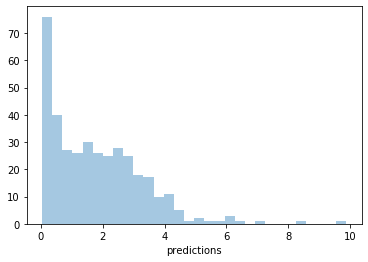

In [44]:
sns.distplot(test_copy['predictions'], kde=False, bins=30)

In [45]:
test_copy.shape

(376, 8)

In [46]:
test_copy.to_parquet('gw1_v1_player_predictions.parquet', index=False)